In [26]:
import pandas as pd
import numpy as np

### **Load data**

In [5]:
#Reading user file:
u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)
users.head() #uncomment this to see some few examples

Number of users: 943


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [8]:
#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

rate_train = pd.read_csv('./data/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
rate_test = pd.read_csv('./data/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')

# rate_train = ratings_base.as_matrix()
# rate_test = ratings_test.as_matrix()

print('Number of traing rates:', rate_train.shape[0])
print('Number of test rates:', rate_test.shape[0])

Number of traing rates: 90570
Number of test rates: 9430


In [10]:
print(rate_train.head())
print(rate_test.head())

   user_id  movie_id  rating  unix_timestamp
0        1         1       5       874965758
1        1         2       3       876893171
2        1         3       4       878542960
3        1         4       3       876893119
4        1         5       3       889751712
   user_id  movie_id  rating  unix_timestamp
0        1        20       4       887431883
1        1        33       4       878542699
2        1        61       4       878542420
3        1       117       3       874965739
4        1       155       2       878542201


### **Establish item profiles**

In [117]:
#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 
        'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
        'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('./data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')

n_items = items.shape[0]
print('Number of items:', n_items)
items.head(3)

Number of items: 1682


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
item_counter = items.iloc[:,5:]
item_counter.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [151]:
from sklearn.feature_extraction.text import TfidfTransformer

In [23]:
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(item_counter).toarray()

In [25]:
print(tfidf.shape)
tfidf

(1682, 19)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.53676706, 0.65097024, ..., 0.53676706, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### **Build model**

In [181]:
from sklearn.linear_model import Ridge
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [193]:
class ContentBasedWithRating():
    def __init__(self, tfidf:TfidfTransformer) -> None:
        self.d = tfidf.shape[1]
        self.W = np.zeros((self.d, n_users))
        self.b = np.zeros((1, n_users))
        self.Yhat = None
    
    def get_items_rated_by_user(self, rate_matrix, user_id) -> tuple:
        """
        in each line of rate_matrix, we have infor: user_id, item_id, rating (scores), time_stamp
        we care about the first three values
        return (item_ids, scores) rated by user user_id
        """
        y = rate_matrix.iloc[:,0] # all users
        
        ids = np.where(y == user_id)[0] # users = user_id
        item_ids = rate_matrix.iloc[ids, 1] # movie_ids of user_id
        scores = rate_matrix.iloc[ids, 2] # rates of those movie_ids
        return item_ids, scores

    def fit_transform(self, rate_train:iter, n_users:int):
        for n in range(1, n_users+1):    
            ids, scores = self.get_items_rated_by_user(rate_train, n)
            clf = Ridge(alpha=0.01, fit_intercept = True)
            Xhat = tfidf[ids-1, :]
            
            clf.fit(Xhat, scores) 
            self.W[:, n-1] = clf.coef_
            self.b[0, n-1] = clf.intercept_
            
        self.Yhat = tfidf.dot(self.W) + self.b
            
    def predict(self, user_id:int, rate_test:iter, Yhat) -> tuple:
        np.set_printoptions(precision=2) # 2 digits after . 
        movie_ids, scores = self.get_items_rated_by_user(rate_test, user_id)
        print('Rated movies ids :', movie_ids.to_list())
        print('True ratings     :', scores.to_list())
        print('Predicted ratings:', Yhat[movie_ids-1, user_id-1])
        # Plotting linear regression of rate_test and predicts
        sns.regplot(x=Yhat[movie_ids-1, user_id-1], y=scores)
        plt.xlabel('Predicted scores')
        plt.ylabel('Actual scores')
        
        return movie_ids.to_list(), Yhat[movie_ids-1, user_id-1]
    
    def MSE(self, rates:iter) -> float:
        se = 0
        cnt = 0
        for n in range(1, n_users+1):
            ids, scores_truth = self.get_items_rated_by_user(rates, n)
            scores_pred = self.Yhat[ids-1, n-1]
            e = scores_truth - scores_pred 
            se += (e*e).sum(axis = 0)
            cnt += e.size 
        return math.sqrt(se/cnt)

In [194]:
recommender = ContentBasedWithRating(tfidf=tfidf)

In [195]:
recommender.fit_transform(rate_train, n_users)

Rated movies ids : [7, 16, 100, 175, 285, 461, 486, 488, 504, 611]
True ratings     : [4, 4, 5, 3, 5, 3, 4, 5, 5, 5]
Predicted ratings: [4.37 3.94 4.44 4.29 4.17 4.17 3.94 4.36 4.46 4.79]


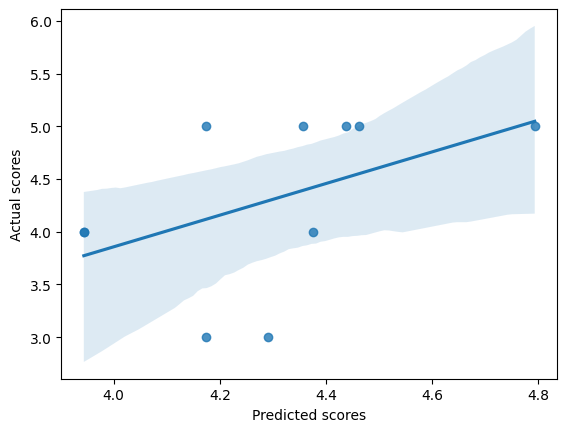

In [196]:
y_pred = recommender.predict(10, rate_test, recommender.Yhat)

In [197]:
print('RMSE for training:', recommender.MSE(rate_train))
print('RMSE for testing', recommender.MSE(rate_test))

RMSE for training: 0.908980456282672
RMSE for testing 1.2703282700393035


In [204]:
items.iloc[y_pred[0],1]

7                                            Babe (1995)
16                            From Dusk Till Dawn (1996)
100                                   Heavy Metal (1981)
175                                        Aliens (1986)
285                          English Patient, The (1996)
461    Like Water For Chocolate (Como agua para choco...
486                                 Roman Holiday (1953)
488                                     Notorious (1946)
504                             Dial M for Murder (1954)
611                                  Lost Horizon (1937)
Name: movie title, dtype: object